In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvcc -V

/bin/bash: line 1: nvcc: command not found


In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cpu
Count of using GPUs: 0


In [10]:
def display_images(image_paths, title, max_images=5):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[5:max_images+5]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [11]:
categories = ['Train calculus', 'Train caries', 'Train discoloration', 'Train hypodontia', 'Train ulcers',
              'Val calculus', 'Val caries', 'Val discoloration', 'Val hypodontia', 'Val ulcers',
              'Test calculus', 'Test caries', 'Test discoloration', 'Test hypodontia', 'Test ulcers']


for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red', 'black'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.0 MB/s eta 0:00:00


In [14]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),
            iaa.Sometimes(0.1, iaa.CLAHE()),
            iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))),
            iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Sometimes(0.3, iaa.CropAndPad(percent=(-0.1, 0.1))),
            iaa.Sometimes(0.1, iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
            iaa.Sometimes(0.1, iaa.MultiplySaturation((0.8, 1.2))),
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [15]:

class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [16]:
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:

train_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/val', imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

In [18]:
def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')


    rows = 2
    cols = 4
    for i, label in enumerate(labels[:8]):
        class_name = idx_to_class[label.item()]
        x = (i % cols) * (img.shape[1] // cols) + (img.shape[1] // cols) // 2
        y = (i // cols) * (img.shape[0] // rows) + (img.shape[0] // rows) // 2
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14,
                 horizontalalignment='center', verticalalignment='center')

    plt.show()

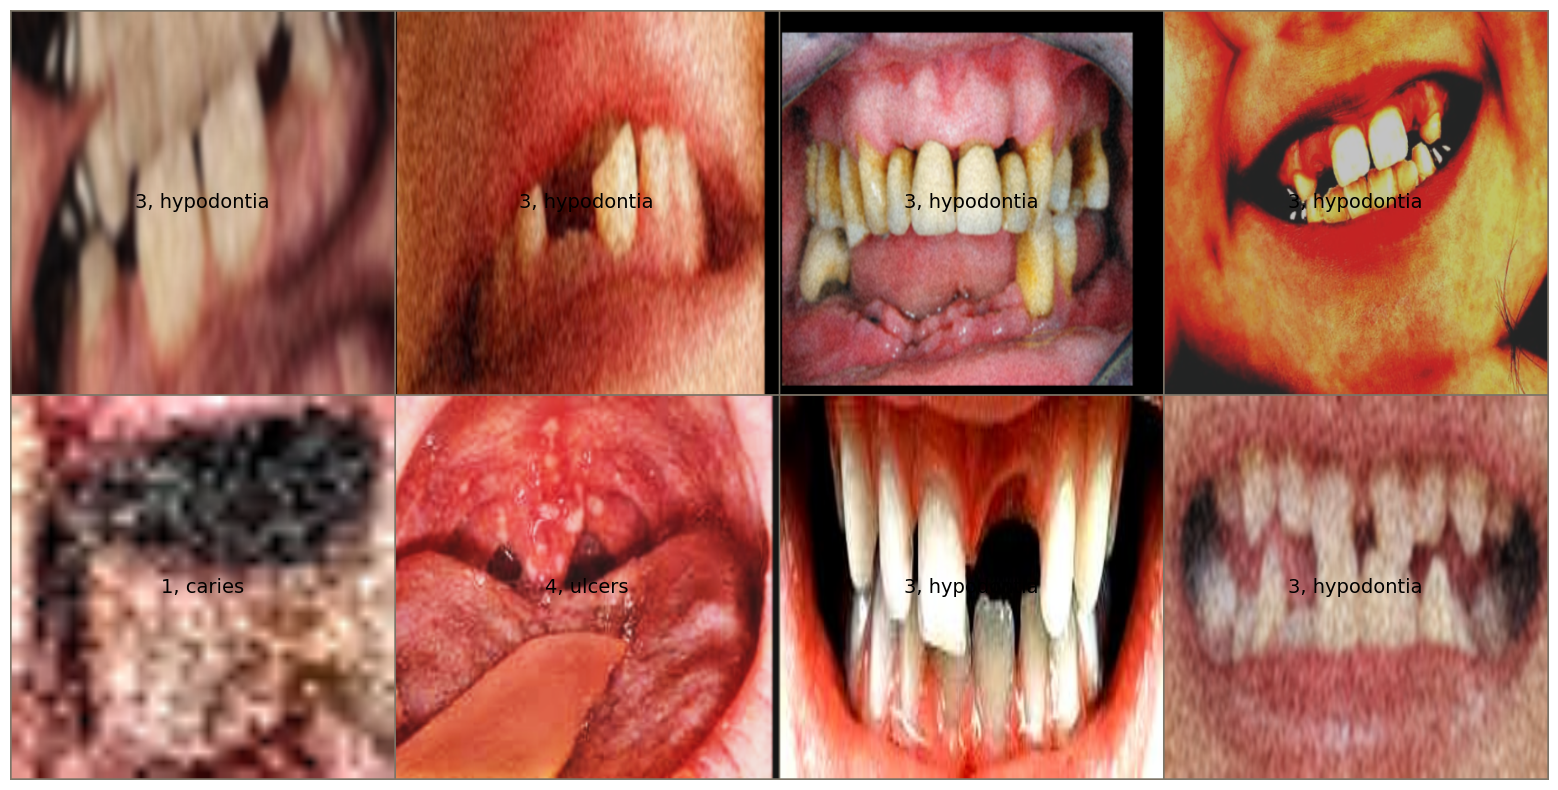

In [19]:
dataiter = iter(train_loader)
images, label = next(dataiter)

class_to_idx = train_loader.dataset.class_to_idx

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

In [20]:
efficientnet = models.efficientnet_b5(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False

efficientnet.classifier[1] = nn.Linear(2048, 5)
# efficientnet.classifier[1].requires_grad = True

for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 154MB/s] 


In [21]:

criterion = nn.CrossEntropyLoss()

In [22]:
!pip install lion-pytorch

In [23]:
!pip install sam-pytorch

In [24]:
from lion_pytorch import Lion
from sam import SAM

In [26]:
base_optimizer = torch.optim.AdamW

In [29]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'Lion':
        optimizer = Lion(net.parameters(), lr=0.00003, betas=(0.9, 0.999), weight_decay=1e-2)
    elif optimizer_name == 'SAM':
        optimizer = SAM(net.parameters(), base_optimizer, lr=0.00003, weight_decay=1e-2)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        correct = 0
        net.eval()
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('RAdam', efficientnet, train_loader, val_loader, criterion, num_epochs=50)

Epoch 1/50: 100%|██████████| 69/69 [02:52<00:00,  2.50s/it]


[RAdam] Epoch 1, Train Loss: 1.515441, Val Loss: 1.572105, Validation Accuracy: 31.81%


Epoch 2/50: 100%|██████████| 69/69 [02:19<00:00,  2.02s/it]


[RAdam] Epoch 2, Train Loss: 1.432755, Val Loss: 1.537933, Validation Accuracy: 38.57%


Epoch 3/50: 100%|██████████| 69/69 [02:18<00:00,  2.00s/it]


[RAdam] Epoch 3, Train Loss: 1.340877, Val Loss: 1.495974, Validation Accuracy: 47.35%


Epoch 4/50: 100%|██████████| 69/69 [02:19<00:00,  2.02s/it]


[RAdam] Epoch 4, Train Loss: 1.274518, Val Loss: 1.452431, Validation Accuracy: 52.29%


Epoch 5/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 5, Train Loss: 1.219387, Val Loss: 1.419926, Validation Accuracy: 54.48%


Epoch 6/50: 100%|██████████| 69/69 [02:18<00:00,  2.00s/it]


[RAdam] Epoch 6, Train Loss: 1.181257, Val Loss: 1.383937, Validation Accuracy: 57.59%


Epoch 7/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 7, Train Loss: 1.128043, Val Loss: 1.344623, Validation Accuracy: 59.41%


Epoch 8/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 8, Train Loss: 1.090080, Val Loss: 1.305983, Validation Accuracy: 62.34%


Epoch 9/50: 100%|██████████| 69/69 [02:20<00:00,  2.04s/it]


[RAdam] Epoch 9, Train Loss: 1.072397, Val Loss: 1.281899, Validation Accuracy: 63.07%


Epoch 10/50: 100%|██████████| 69/69 [02:21<00:00,  2.05s/it]


[RAdam] Epoch 10, Train Loss: 1.036805, Val Loss: 1.242937, Validation Accuracy: 65.81%


Epoch 11/50: 100%|██████████| 69/69 [02:19<00:00,  2.03s/it]


[RAdam] Epoch 11, Train Loss: 0.999715, Val Loss: 1.216667, Validation Accuracy: 66.91%


Epoch 12/50: 100%|██████████| 69/69 [02:23<00:00,  2.07s/it]


[RAdam] Epoch 12, Train Loss: 0.974844, Val Loss: 1.200304, Validation Accuracy: 67.82%


Epoch 13/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 13, Train Loss: 0.957219, Val Loss: 1.163316, Validation Accuracy: 68.92%


Epoch 14/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 14, Train Loss: 0.933537, Val Loss: 1.139125, Validation Accuracy: 70.38%


Epoch 15/50:  42%|████▏     | 29/69 [01:00<01:26,  2.16s/it]

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

In [ ]:
class_folders = {
    'calculus': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/calculus',
    'caries': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/caries',
    'discoloration': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/discoloration',
    'hypodontia': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/hypodontia',
    'ulcers': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/ulcers'
}

idx_to_class = {idx: class_name for idx, class_name in enumerate(class_folders.keys())}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        if counter > 10:
            break

        image = load_and_transform_image(image_path, pytorch_transforms)
        efficientnet.eval()
        with torch.no_grad():
            outputs = efficientnet(image)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
        prediction = idx_to_class[predicted.item()]

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1

        if counter > 10:
            break

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform, target_class):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    class_to_idx = {'calculus': 0, 'caries': 1, 'discoloration': 2, 'hypodontia': 3, 'ulcers': 4}


    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                prediction = predicted.item()
                all_preds.append(prediction)
                all_labels.append(class_to_idx[class_name])

    target_preds = [1 if pred == class_to_idx[target_class] else 0 for pred in all_preds]
    target_labels = [1 if label == class_to_idx[target_class] else 0 for label in all_labels]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(target_labels, target_preds, average='weighted')
    recall = recall_score(target_labels, target_preds, average='weighted')
    f1 = f1_score(target_labels, target_preds, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
for class_name in class_folders.keys():
    metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms, class_name)
    print(f"{class_name.capitalize()} Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('Lion', efficientnet, train_loader, val_loader, criterion, num_epochs=50)

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for class_name in class_folders.keys():
    metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms, class_name)
    print(f"{class_name.capitalize()} Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('Lion', efficientnet, train_loader, val_loader, criterion, num_epochs=50)

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for class_name in class_folders.keys():
    metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms, class_name)
    print(f"{class_name.capitalize()} Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")